In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 27
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

In [5]:
train_df.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [6]:
def show_train_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = '/kaggle/input/shopee-product-detection-open/train/train/train/'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        retval, threshold = cv2.threshold(img,205,255,cv2.THRESH_BINARY)
        img = cv2.cvtColor(threshold, cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

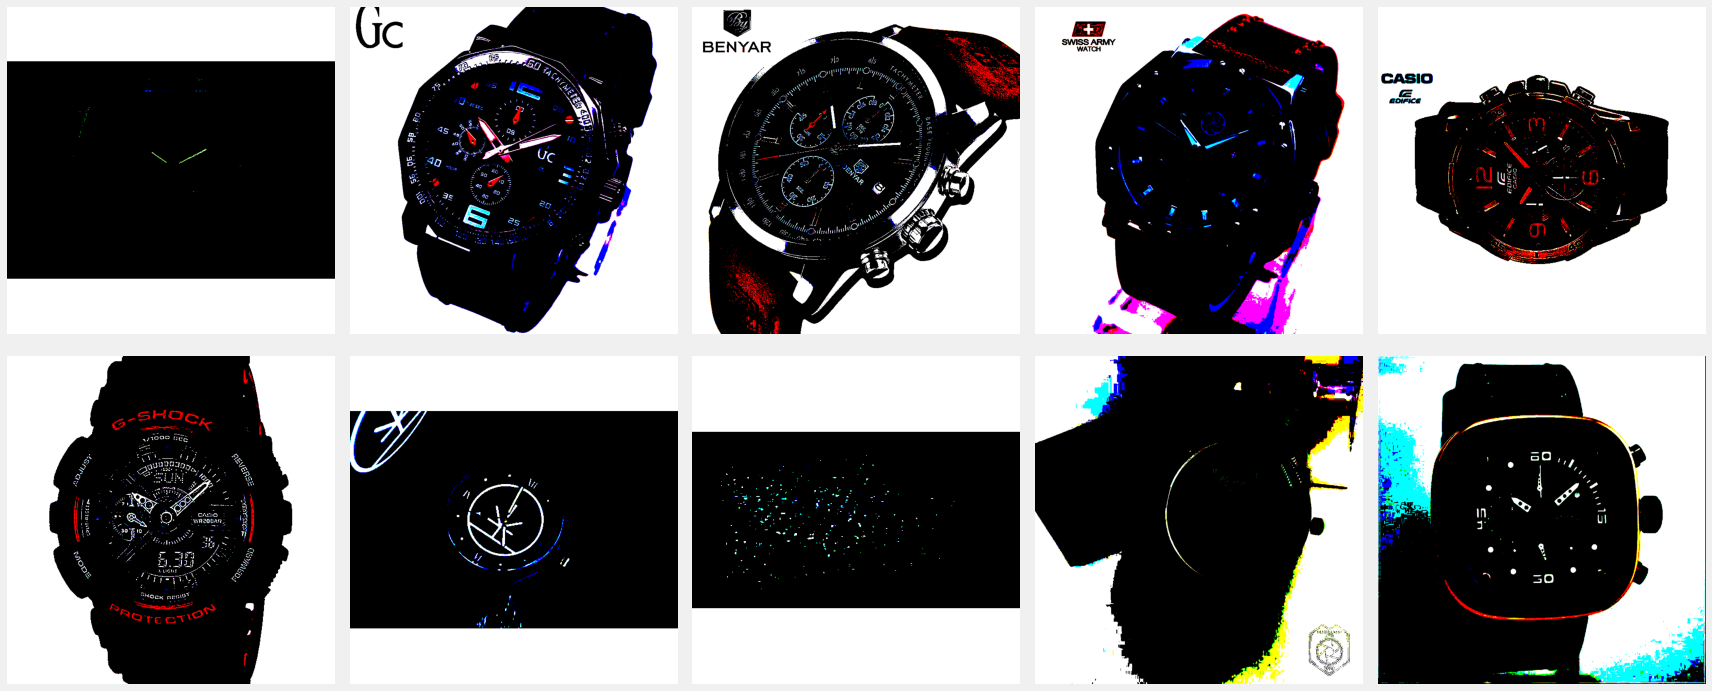

In [7]:
show_train_img('24')

In [8]:
dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
    try:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(2200)
    except:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)

In [9]:
# Making the real path to access the data
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [10]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [11]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.1, 
                                                                        random_state=2020)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((80182,), (8910,), (80182, 42), (8910, 42))

In [13]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    
test_paths = np.array(test_paths)

In [14]:
def decode_image(filename, label=None, image_size=(380, 380)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [15]:
def add_contrast(image,label=None,c=5):
    image = tf.image.adjust_contrast(image,c)
    
    if label is None:
        return image
    else:
        return image, label

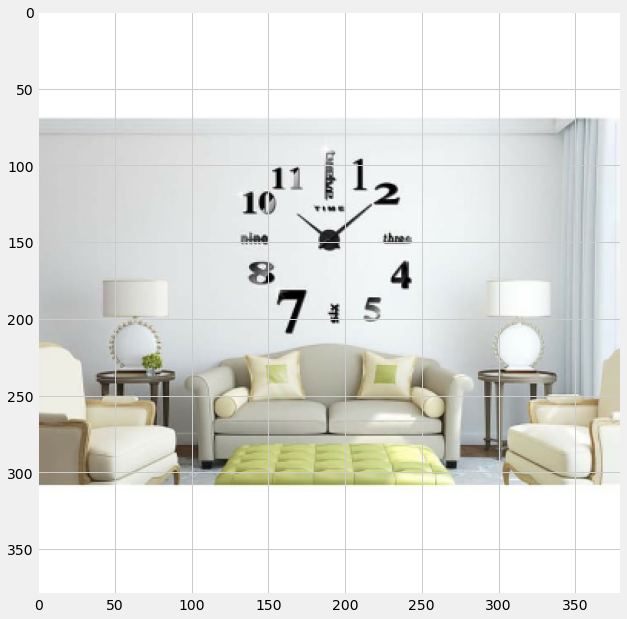

In [18]:
img = add_contrast(decode_image(train_paths[30]),c=5)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [17]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [ ]:
# Add Image Augmentation: random flip left right
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(add_contrast, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(add_contrast, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .map(add_contrast, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [ ]:
# Efficient-Net: a Google released CNN model
!pip install -q efficientnet

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB7

In [ ]:
%%time

with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB7(weights='imagenet', # noisy-student
                       include_top=False,
                       pooling='avg'), # max
        
        Dense(42, activation='softmax')
    ])
    
    model.layers[0].trainable = False
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()

In [ ]:
n_steps = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
)

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
pred = model.predict(test_dataset, verbose=1)

In [ ]:
# drop existing feature
test_df = test_df.drop('category', axis=1)

# change with prediction
test_df['category'] = pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [ ]:
test_df.to_csv('submission.csv', index=False)